In [9]:
import pandas as pd
import numpy as np
import glob
import os
import gc
import json 
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client, wait, LocalCluster

In [2]:
base_path = '../../data'

In [3]:
ssubm = pd.read_csv(base_path + '/sample_submission.csv')

ssubm_df = ssubm["site_path_timestamp"].apply(lambda x: pd.Series(x.split("_")))
used_buildings = sorted(ssubm_df[0].value_counts().index.tolist())

floor_map = {"B2":-2, "B1":-1, "F1":0, "F2": 1, "F3":2, "F4":3, "F5":4, "F6":5, "F7":6,"F8":7, "F9":8,
             "1F":0, "2F":1, "3F":2, "4F":3, "5F":4, "6F":5, "7F":6, "8F": 7, "9F":8}

In [7]:
def to_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)

### site内で50回以上登場するWiFiを抽出
100とかにしたかったが対象となるWiFiが少なすぎる。testのwaypointに紐づくWiFiの件数が少ない

In [4]:
%%time

# TODO 全体の登場回数ではなく、waypointの近くの登場回数で絞るべき
WIFI_USE_COUT = 50

bssid = dict()

for building in used_buildings:
    #break
    folders = sorted(glob.glob(os.path.join(base_path,'train/'+building+'/*')))
    print(building)
    wifi = list()
    for folder in folders:
        floor = floor_map[folder.split('\\')[-1]]
        files = glob.glob(os.path.join(folder, "*.txt"))
        for file in files:
            with open(file, encoding='utf-8') as f:
                txt = f.readlines()
                for e, line in enumerate(txt):
                    tmp = line.strip().split()
                    if tmp[1] == "TYPE_WIFI":
                        wifi.append(tmp)
    df = pd.DataFrame(wifi)
    value_counts = df[3].value_counts()
    top_bssid = value_counts[value_counts > WIFI_USE_COUT].index.tolist() # 50回以上登場するBSSIDのみを対象にする。
    print(len(top_bssid))
    bssid[building] = top_bssid
    del df
    del wifi
    gc.collect()

5a0546857ecc773753327266
2838
5c3c44b80379370013e0fd2b
2630
5d27075f03f801723c2e360f
5606
5d27096c03f801723c31e5e0
831
5d27097f03f801723c320d97
1663
5d27099f03f801723c32511d
724
5d2709a003f801723c3251bf
927
5d2709b303f801723c327472
1432
5d2709bb03f801723c32852c
1817
5d2709c303f801723c3299ee
5209
5d2709d403f801723c32bd39
1382
5d2709e003f801723c32d896
911
5da138274db8ce0c98bbd3d2
298
5da1382d4db8ce0c98bbe92e
2226
5da138314db8ce0c98bbf3a0
957
5da138364db8ce0c98bc00f1
506
5da1383b4db8ce0c98bc11ab
1213
5da138754db8ce0c98bca82f
938
5da138764db8ce0c98bcaa46
1288
5da1389e4db8ce0c98bd0547
448
5da138b74db8ce0c98bd4774
2956
5da958dd46f8266d0737457b
2936
5dbc1d84c1eb61796cf7c010
3791
5dc8cea7659e181adb076a3f
3044
Wall time: 6min 14s


In [5]:
with open(f"bssid_{WIFI_USE_COUT}.json", "w") as f:
    json.dump(bssid, f)

with open(f"bssid_{WIFI_USE_COUT}.json") as f:
    bssid = json.load(f)

## train作成

In [6]:
%%time

TIME_DIFF_THRESHOLD = 5000 # 抽出対象とする最大時間（ミリ秒）
WIFI_NUM = 100 # WiFi抽出件数
WIFI_MIN_NUM = 10 # waypointに紐づくWiFiの最低数（この数以下の場合は学習データから除外する）
DUMMY_RECORD = [9999999999999,	'DUMMY', 'NONE', 'NONE', -999, 0, 9999999999999, 99999, 99999] # waypointに紐づくWiFi数が100件に満たない場合に穴埋めするためのダミー

train_save_file_name = f'train_{TIME_DIFF_THRESHOLD}_{WIFI_NUM}_{WIFI_MIN_NUM}_{WIFI_USE_COUT}.pkl'
test_save_file_name = f'test_{TIME_DIFF_THRESHOLD}_{WIFI_NUM}_{WIFI_USE_COUT}.pkl'

train_wifi_count = []
rows = []

for building in tqdm(used_buildings):
    bssids = bssid[building]

    for folder in sorted(glob.glob(os.path.join(base_path,'train', building +'/*'))):
        floor_str = folder.split('\\')[-1]
        floor = floor_map[floor_str]
        
        for file in glob.glob(os.path.join(folder, "*.txt")):
            wifi = list()
            waypoint = list()
            
            with open(file, encoding='utf-8') as f:
                txt = f.readlines()
                
            for line in txt:
                line = line.strip().split()
                if line[1] == "TYPE_WAYPOINT":
                    waypoint.append(line)
                if line[1] == "TYPE_WIFI":
                    wifi.append(line)

            if len(wifi) <= 0:
                continue
                    
            wifi_base_df = pd.DataFrame(np.array(wifi), columns=['timestamp', 'data_type', 'ssid', 'bssid', 'rssi', 'frequency', 'last_seen_timestamp'])
            
            for wp_row in waypoint:
                wifi_df = wifi_base_df.copy()
                
                wifi_df = wifi_df[wifi_df['bssid'].isin(bssids)]
                
                wp_timestamp = wp_row[0]

                wifi_df['time_diff'] = wifi_df['last_seen_timestamp'].astype(np.float) - int(wp_timestamp)
                wifi_df['time_diff_abs'] = wifi_df['time_diff'].abs()
                
                # waypointに近いWiFi(last_seen_timestamp)のみ抽出
                wifi_df = wifi_df[np.abs(wifi_df['time_diff']) < TIME_DIFF_THRESHOLD] 
                
                # 同一 SSID * BSSIDのうちtime_diffが一番小さいもののみを抽出する
                wifi_df = wifi_df.sort_values('time_diff_abs')
                wifi_df = wifi_df.groupby(['ssid', 'bssid']).head(1).reset_index(drop=True)

                wifi_count = len(wifi_df)
                train_wifi_count.append(wifi_count)
                
                # WiFiが最低件数に満たない場合はスキップする
                if wifi_count < WIFI_MIN_NUM:
                    continue
                
                # WiFi件数に満たない行を埋める
                dummy_count = WIFI_NUM - wifi_count
                if dummy_count > 0:
                    dummy_df = pd.DataFrame(np.tile(DUMMY_RECORD, (dummy_count, 1)), 
                                            columns=['timestamp', 'data_type', 'ssid', 'bssid', 'rssi', 'frequency', 'last_seen_timestamp', 'time_diff', 'time_diff_abs'])
                    wifi_df = pd.concat([wifi_df, dummy_df])
                    
                wifi_df = wifi_df.head(100)
                
                row = np.concatenate([wifi_df['ssid'].to_numpy(),
                                      wifi_df['bssid'].to_numpy(), 
                                      wifi_df['rssi'].to_numpy(), 
                                      wifi_df['frequency'].to_numpy(), 
                                      wifi_df['time_diff'].to_numpy(),
                                      [wp_row[0], # waypoint timestamp
                                      wp_row[2], # x
                                      wp_row[3], # y
                                      floor, # floor number
                                      floor_str, # floor string
                                      file.split('\\')[-1].split('.')[0], # path_id
                                      building, # site_id
                                      wifi_count]
                                     ])
                rows.append(row)

columns = [f'ssid_{i}' for i in range(WIFI_NUM)] + [f'bssid_{i}' for i in range(WIFI_NUM)] + [f'rssi_{i}' for i in range(WIFI_NUM)] + [f'frequency_{i}' for i in range(WIFI_NUM)] +  [f'time_diff_{i}' for i in range(WIFI_NUM)] +  ['wp_tmestamp', 'x', 'y', 'floor', 'floor_str', 'path_id', 'site_id', 'wifi_count']
train_df = pd.DataFrame(rows, columns=columns)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [16:07<00:00, 40.31s/it]


Wall time: 16min 13s


In [22]:
to_pickle(train_save_file_name, train_df)

In [11]:
train_df.shape

(73455, 508)

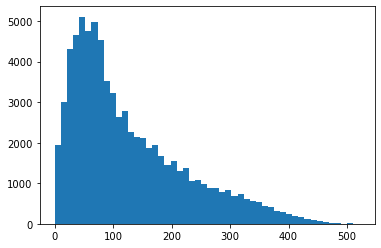

,count,mean,std,min,25%,50%,75%,max
0,75206.0,126.683323,97.704373,0.0,52.0,96.0,181.0,521.0


In [13]:
plt.hist(train_wifi_count, bins=50)
plt.show()
pd.DataFrame(train_wifi_count).describe().T

## test作成
※ testのpathファイルにWiFiが存在しないデータはtimestampが不明であるため除外する

In [14]:
realtime_sample_submission_df = pd.read_csv('real_timestamp_sample_submission.csv')
test_len = len(realtime_sample_submission_df)

realtime_sample_submission_df = realtime_sample_submission_df[realtime_sample_submission_df['is_real_timestamp']]
test_len - len(realtime_sample_submission_df)

493

493件は別のデータセットで学習したモデルで予測する必要あり。

In [15]:
site_path_time_df = realtime_sample_submission_df['site_path_timestamp'].str.split('_').apply(lambda x: pd.Series(x))
site_path_time_df.columns = ['site_id', 'path_id', 'waypoint_timestamp']
site_path_time_df['site_path_timestamp'] = realtime_sample_submission_df['site_path_timestamp']
site_path_time_df.head(3)

,site_id,path_id,waypoint_timestamp,site_path_timestamp
0,5da1389e4db8ce0c98bd0547,00ff0c9a71cc37a2ebdd0f05,1573190310863,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...
1,5da1389e4db8ce0c98bd0547,00ff0c9a71cc37a2ebdd0f05,1573190314901,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...
2,5da1389e4db8ce0c98bd0547,00ff0c9a71cc37a2ebdd0f05,1573190323379,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...


In [16]:
%%time

test_wifi_count = []
test_rows = []

def create_wifi_df(path_id):
    wifi = list()
    
    with open(os.path.join(f'../../data/test/{path_id}.txt'), encoding='utf-8') as f:
        txt = f.readlines()

    for line in txt:
        line = line.strip().split()
        if line[1] == "TYPE_WIFI":
            wifi.append(line)
            
    return pd.DataFrame(np.array(wifi), columns=['timestamp', 'data_type', 'ssid', 'bssid', 'rssi', 'frequency', 'last_seen_timestamp'])
            

for path_id, path_df in site_path_time_df.groupby('path_id'):
    
    site_id = path_df.iloc[0]['site_id']
    bssids = bssid[site_id]
    
    wifi_base_df = create_wifi_df(path_id)
    wifi_base_df = wifi_base_df[wifi_base_df['bssid'].isin(bssids)] # 指定の件数以下の登場回数のWiFiは除外
    
    for i, path_row in path_df.iterrows():
        wifi_df = wifi_base_df.copy()
        site_path_timestamp = path_row['site_path_timestamp']
        waypoint_timestamp = path_row['waypoint_timestamp']
        
        wifi_df['time_diff'] = wifi_df['last_seen_timestamp'].astype(np.float) - int(waypoint_timestamp)
        wifi_df['time_diff_abs'] = wifi_df['time_diff'].abs()
        
        wifi_df = wifi_df[wifi_df['time_diff_abs'] < TIME_DIFF_THRESHOLD] 
        wifi_df = wifi_df.sort_values('time_diff_abs')
        wifi_df = wifi_df.groupby(['ssid', 'bssid']).head(1).reset_index(drop=True)
        
        wifi_count = len(wifi_df)
        
        test_wifi_count.append(wifi_count)
        
        dummy_count = WIFI_NUM - wifi_count
        if dummy_count > 0:
            dummy_df = pd.DataFrame(np.tile(DUMMY_RECORD, (dummy_count, 1)), 
                                    columns=['timestamp', 'data_type', 'ssid', 'bssid', 'rssi', 'frequency', 'last_seen_timestamp', 'time_diff', 'time_diff_abs'])

        wifi_df = pd.concat([wifi_df, dummy_df]).head(WIFI_NUM)

        test_row = np.concatenate([wifi_df['ssid'].to_numpy(),
                              wifi_df['bssid'].to_numpy(), 
                              wifi_df['rssi'].to_numpy(), 
                              wifi_df['frequency'].to_numpy(), 
                              wifi_df['time_diff'].to_numpy(),
                              [waypoint_timestamp, # waypoint timestamp
                              path_id, # path_id
                              building, # site_id
                              site_path_timestamp,
                              wifi_count]
                             ])
        test_rows.append(test_row)
            
columns = [f'ssid_{i}' for i in range(WIFI_NUM)] + [f'bssid_{i}' for i in range(WIFI_NUM)] + [f'rssi_{i}' for i in range(WIFI_NUM)] + [f'frequency_{i}' for i in range(WIFI_NUM)] +  [f'time_diff_{i}' for i in range(WIFI_NUM)] +  ['wp_tmestamp', 'path_id', 'site_id', 'site_path_timestamp', 'wifi_count']
test_df = pd.DataFrame(test_rows, columns=columns)

Wall time: 2min 4s


In [18]:
to_pickle(test_save_file_name, test_df)

In [19]:
test_df.shape

(9640, 505)

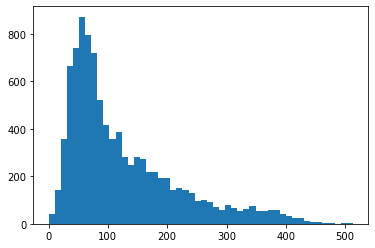

,count,mean,std,min,25%,50%,75%,max
0,9640.0,125.318983,93.775387,0.0,57.0,92.0,170.0,513.0


In [20]:
plt.hist(test_wifi_count, bins=50)
plt.show()
pd.DataFrame(test_wifi_count).describe().T

In [21]:
test_wifi_count_np = np.array(test_wifi_count)
print('WiFi10件以下の件数:{}'.format(len(test_wifi_count_np[test_wifi_count_np <= 10])))
print('WiFi20件以下の件数:{}'.format(len(test_wifi_count_np[test_wifi_count_np <= 20])))

WiFi10件以下の件数:41
WiFi20件以下の件数:185
